# Music styles variational autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from os import listdir

%matplotlib inline

## Data

Load raw wave data.

In [2]:
def load_raw_file(path, size_cut=False):
    raw = np.fromfile(path, dtype='uint8') / 255
    if size_cut:
        return raw[:size_cut]
    return raw

In [3]:
# parameter
dir_with_styles = '/run/media/cozzy/data/music_samples/styles_16000Hz_131072B_u8/'

styles = listdir(dir_with_styles)

styles

['Funk',
 'Reggae',
 'Hardstyle',
 'Punk',
 'Grunge',
 'Ambient',
 'Stoner Metal',
 'Drum and Bass',
 'Rock-and-Roll',
 'Psychill',
 'Trance',
 'Grindcore',
 'Jazz',
 'Drone',
 'Dubstep',
 'Ska',
 'Pop Rock',
 'Blues',
 'Pop',
 'Metal',
 'Disco',
 'Tekno',
 'Techno',
 'House',
 'Classical',
 'Stoner Rock',
 'Djent',
 'Grime',
 'Black Metal',
 'Doom Metal',
 'Neurofunk',
 'Rock',
 'Rap',
 'Country',
 'Hip Hop',
 'Thrash Metal',
 'Folk',
 'Death Metal']

In [4]:
# parameter
selected_styles = [
    'Black Metal',
    'Death Metal',
    'Grindcore',
    'House',
    'Techno',
    'Trance'
]

cut_size = 16000

labels = []
tracks = []
ids = []
label = 0
for s in selected_styles:
    style_tracks = listdir(dir_with_styles + s)
    tracks += [load_raw_file(dir_with_styles + s + '/' + t, cut_size) for t in style_tracks]
    labels += ([label] * len(style_tracks))
    ids += style_tracks
    label += 1

labels = np.array(labels)
tracks = np.array(tracks)
ids = np.array(ids)

In [5]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

train_shuf, lables_shuf, ids_shuf = unison_shuffled_copies(tracks, labels, ids)

Arcturus - The Arcturian Sign.raw
Black Metal
Whole sample    |     First 1000 B    |    First 100 B    


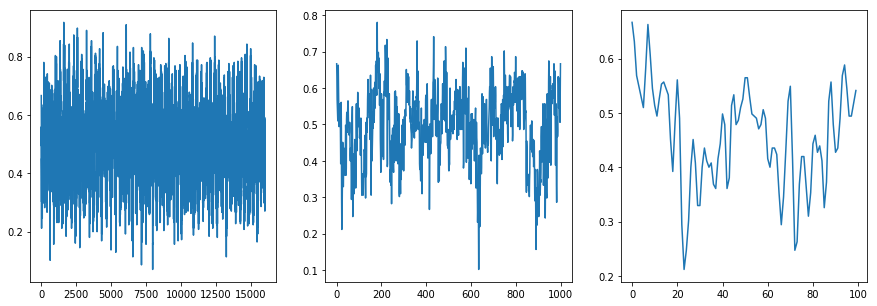

In [6]:
i = 0
data = train_shuf[i]
print(ids_shuf[i])
print(selected_styles[lables_shuf[i]])
print('Whole sample    |     First 1000 B    |    First 100 B    ')
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(data)
plt.subplot(1, 3, 2)
plt.plot(data[:1000])
plt.subplot(1, 3, 3)
plt.plot(data[:100])
plt.show()

## Encoder

In [7]:
def leaky_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

# parameters
activation = leaky_relu
drop_rate = 0.02

def encoder(x_input, hidden_layers_cnt, latent_size):
    with tf.variable_scope("encoder", reuse=None):
        
        x = x_input
        connections = 0

        in_size = int(x.shape[1])
        log_size = int(np.ceil(np.log2(in_size)))
        log_latent = int(np.ceil(np.log2(latent_size)))
        log_layer_sizes = np.linspace(log_size, log_latent, hidden_layers_cnt + 2, dtype=int)
        
#         x = tf.layers.dropout(x, rate=drop_rate, training=is_training)
        
        print(in_size, end='')
        for lls in log_layer_sizes[1:-1]:
            layer_size = 2**lls
            print(" ->", layer_size, end='')
            connections += int(x.shape[1]) * layer_size
            x = tf.layers.dense(x, units=layer_size, activation=activation)
        print(" ->", latent_size)
        connections += int(x.shape[1]) * latent_size
        x = tf.layers.dense(x, units=latent_size, activation=activation)
        
        mean  =       tf.layers.dense(x, units=latent_size, activation=activation)
        sd    = 0.5 * tf.layers.dense(x, units=latent_size, activation=activation)            
        eps   = tf.random_normal(tf.stack([tf.shape(x)[0], latent_size])) 
        z     = mean + tf.multiply(eps, tf.exp(sd))
        
        print('Encoder memory:', (4 * connections) // 10**6, 'MB')
        
        return z, mean, sd, eps

## Decoder

In [8]:
activation = leaky_relu

def decoder(sampled_z, hidden_layers_cnt, output_size):
    with tf.variable_scope("decoder", reuse=None):
        
        x = sampled_z
        connections = 0

        latent_size = int(sampled_z.shape[1])
        log_size = int(np.ceil(np.log2(output_size)))
        log_latent = int(np.ceil(np.log2(latent_size)))
        log_layer_sizes = np.linspace(log_latent, log_size, hidden_layers_cnt + 2, dtype=int)
        
        print(latent_size, end='')
        for lls in log_layer_sizes[1:-1]:
            layer_size = 2**lls
            print(" ->", layer_size, end='')
            connections += int(x.shape[1]) * layer_size
            x = tf.layers.dense(x, units=layer_size, activation=activation)
#             x = tf.layers.dropout(x, rate=drop_rate, training=is_training)
#         print(" ->", output_size, end='')
#         x = tf.layers.dense(x, units=output_size, activation=activation)
        
        print(" -(sigm)>", output_size)
        connections += int(x.shape[1]) * output_size
        wave = tf.layers.dense(x, units=output_size, activation=tf.nn.sigmoid)
        
        print('Decoder memory:', (4 * connections) // 10**6, 'MB')
        return wave

## Construct Network Model

In [9]:
# parameters
latent_size = 2
hidden_layers = 1

for t in train_shuf:
    assert len(t) == len(train_shuf[0])
    
size = len(train_shuf[0])

tf.reset_default_graph()

input_layer  = tf.placeholder(dtype=tf.float32, shape=[None, size], name='input')
# for loss calculation
original_data_layer = tf.placeholder(dtype=tf.float32, shape=[None, size], name='original_data')
is_training = tf.placeholder(tf.bool)

print("Encoder network (dense):")
sampled, mean, sd, eps = encoder(input_layer, hidden_layers, latent_size)
print()
print("Decoder network (dense):")
dec = decoder(sampled, hidden_layers, size)

Encoder network (dense):
16000 -> 128 -> 2
Encoder memory: 8 MB

Decoder network (dense):
2 -> 128 -(sigm)> 16000
Decoder memory: 8 MB


## Define loss optimizer

In [10]:
# https://stats.stackexchange.com/questions/341954/balancing-reconstruction-vs-kl-loss-variational-autoencoder

# parameter
learning_rate = 0.001

temperature = tf.Variable(1.0, name='temperature', trainable=False)

wave_loss = tf.reduce_sum(tf.squared_difference(dec, original_data_layer), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mean) - tf.exp(2.0 * sd), 1)

wave_loss /= size / 100
latent_loss = tf.multiply(latent_loss, temperature)

loss = tf.reduce_mean(wave_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Before learning (random output)

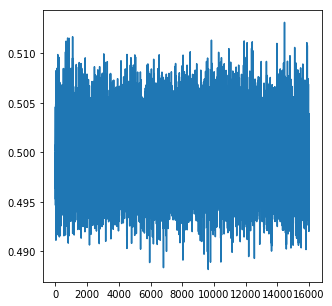

In [11]:
randoms = [np.random.normal(0, 1, latent_size) for _ in range(1)]
gen_wave = sess.run(dec, feed_dict = {sampled: randoms, is_training: False})
plt.figure(figsize=(5, 5))
plt.plot(gen_wave[0])
plt.show()

## Learning

In [12]:
# parameter
path_to_model = './wave_model/model'

def save_model(session):
    saver = tf.train.Saver()
    saver.save(session, path_to_model)
            
def load_model(session):
    loader = tf.train.Saver()
    loader.restore(session, path_to_model)

In [13]:
def next_batch(i, array, batch_size):
    return np.roll(array, -i*batch_size)[:batch_size]

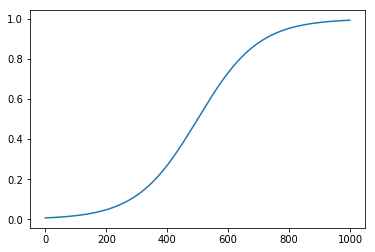

In [14]:
def sigmoid(x, size, steep = 10):
    return 1 / (1 + np.exp((size / 2  - x) * steep / size))

size = 1000
sig = np.array([sigmoid(x, size) for x in range(size)])
plt.plot(sig)
plt.show()

In [15]:
def set_temperature(t):
    sess.run(tf.assign(temperature, t))

In [16]:
# parameters
# batch_size = 227
epochs = 5000
max_temperature = 0.0001

set_temperature(0)

for i in range(epochs):
    # whole set
    batch = train_shuf
    
    if not i % 100:
        ls, d, w_ls, d_ls, mu, sigm = sess.run([loss, dec, wave_loss, latent_loss, mean, sd], 
                                               feed_dict = {input_layer: batch, original_data_layer: batch, is_training: False})
        print(i, ls, np.mean(w_ls), np.mean(d_ls))

            
    sess.run(optimizer, feed_dict = {input_layer: batch, original_data_layer: batch, is_training: True})
            
    # heat it up
    set_temperature(sigmoid(i, epochs) * max_temperature)   


0 2.0224023 2.0224023 0.0


### After learning

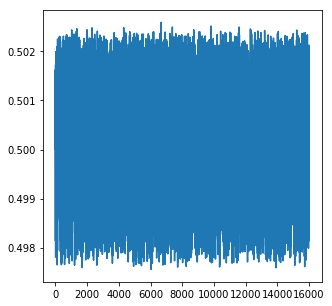

In [17]:
randoms = [np.random.normal(0, 1, latent_size) for _ in range(1)]
gen_wave = sess.run(dec, feed_dict = {sampled: randoms, is_training: False})
plt.figure(figsize=(5, 5))
plt.plot(gen_wave[0])
plt.show()

## Encode

[[-1.5879791  1.7882348]]


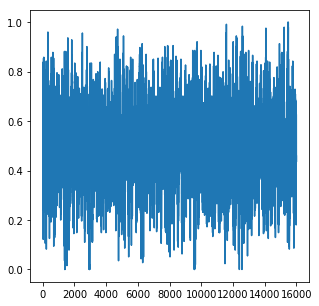

In [18]:
i = np.random.randint(len(train_shuf))
sa = sess.run(sampled, feed_dict = {input_layer: [train_shuf[i]], is_training: False})
print(sa)
plt.figure(figsize=(5, 5))
plt.plot(train_shuf[i])
plt.show()

## Decode the same thing

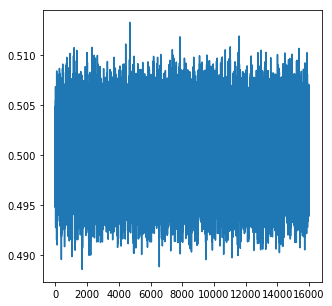

In [19]:
gen_wave = sess.run(dec, feed_dict = {sampled: sa, is_training: False})
plt.figure(figsize=(5, 5))
plt.plot(gen_wave[0])
plt.show()

## Styles scatter plot

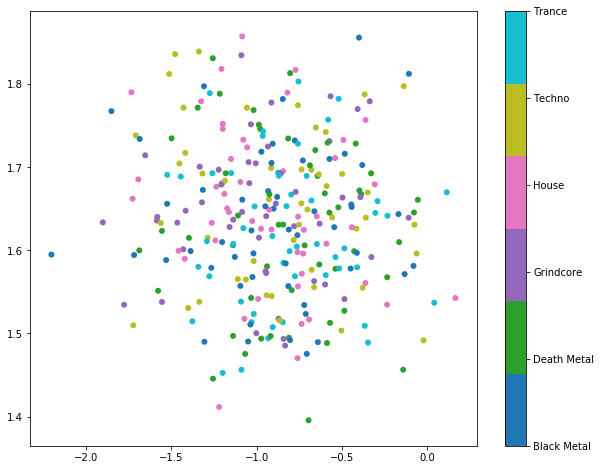

In [22]:
xs = []
ys = []
colors = []
for i in range(300):
    sa = sess.run(sampled, feed_dict = {input_layer: [train_shuf[i]], is_training: False})[0]
    xs.append(sa[0])
    ys.append(sa[1])
    colors.append(lables_shuf[i])


plt.figure(figsize=(10, 8))
plt.scatter(xs, ys,
            c=colors, edgecolor='none', alpha=1,
            cmap=plt.cm.get_cmap('tab10', len(selected_styles)))
cbar = plt.colorbar()
cbar.ax.set_yticklabels(selected_styles)
plt.show()

## Latent space

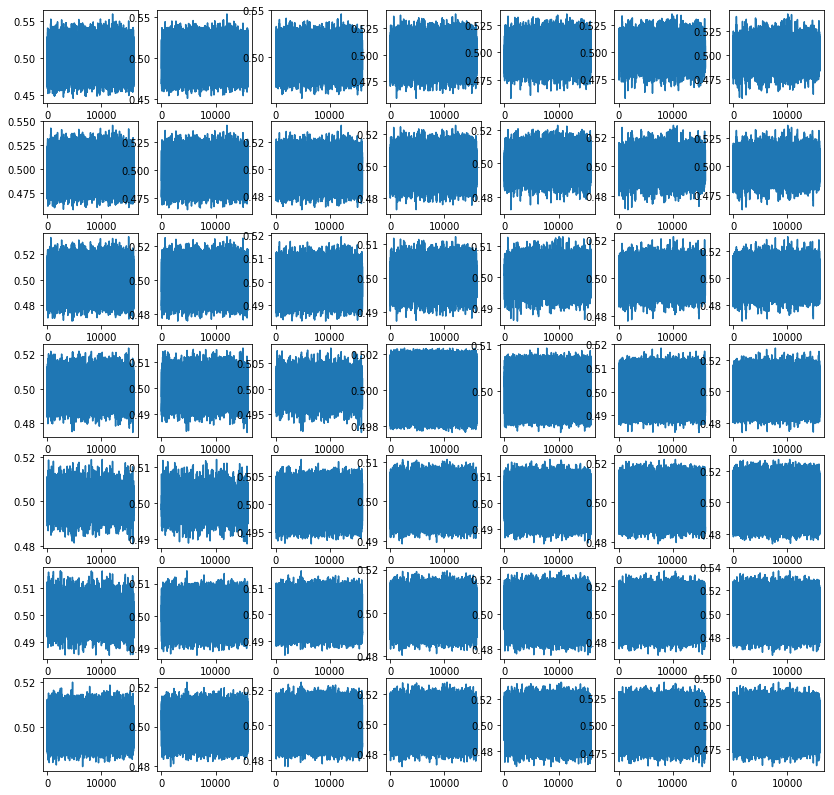

In [21]:
side = 7
size = 2

plt.figure(figsize=(side * size, side * size))

lin = np.linspace(-3, 3, side)

for y in range(0, side):
    for x in range(0, side):
        plt.subplot(side, side, y*side + x + 1)
        latent_v = [lin[x], lin[y]]
        gen_wave = sess.run(dec, feed_dict = {sampled: [latent_v], is_training: False})
        plt.plot(gen_wave[0])
plt.show()